*본 코드는 "What is the secret behind lotto numbers?  \\- Reflections on the fairness of the lotto and winning numbers" 에 대한 파이썬 코드 파일임.

In [2]:
#패키지 import

import pandas as pd
import numpy as np
import itertools
from scipy import stats

### 2장 적합도 검정

#### 2.0.1 피어슨 카이제곱 통계량의 점근 근사이론을 이용한 검정

각 숫자 독립성 검정에서 카이제곱 통계량은
$X^2 \approx \frac{N-k}{N-1}\chi^2_{N-1}$



각 쌍 독립성 검정에서 카이제곱 통계량은
$X^2 ≈ ((k-1)\binom{N-3}{k-2}/\binom{N-2}{k-2})\chi^2_{N-1} + \binom{N-4}{k-2}/\binom{N-2}{k-2}\chi^2_{N(N-3)/2}$, in our case, N=45, k =7

In [3]:
#실제 데이터 분할표 만들기
real = pd.read_excel('korea_lottery_winners.xlsx', header = None)
real = real.iloc[:,:6]
# 각 숫자에 대한 분할표
freqtable1 = pd.Series(real.values.flatten()).value_counts().sort_index()

# 두 숫자의 쌍에 대한 분할표
numbers = list(range(1,46))
combinations = list(itertools.combinations(numbers, 2))

temp = []
for pair in combinations:
  temp.append(sum(all(element in draw for element in pair) for draw in real.values))

freqtable2 = pd.DataFrame(temp, index = combinations)

In [4]:
# 분할표의 카이제곱 통계량 계산하는 함수.
def chisq(table):
      # expected 값은 table 내의 모든 값의 합을 table의 행 개수로 나눈 값
      expected = table.sum() / table.shape[0]
      # chisq 계산
      return ((table - expected) ** 2 / expected).sum()


In [5]:
# Ho에 대한 점근적 카이제곱 검정,

N = 45
k = 6

# #moment-matching 시키면(pair 검정통계량)

# 점근적 독립성 검정

w1 = (N-k)*(k-1)/(N-2)
w2 = ((N-k)*(N-k-1))/((N-2)*(N-3))
w = np.array([w1, w2])

v1 = N-1
v2 = N*(N-3)/2
v = np.array([v1,v2])


b = (((w**3)*v).sum()) / (((w**2)*v).sum())
V = ((((w**2)*v).sum())**3) / ((((w**3)*v).sum())**2)
a = (w*v).sum() - b*V


X2_1 = chisq(freqtable1)
X2_2 = chisq(freqtable2)

print("각 숫자에 대한 점근적 검정 p-value:", stats.chi2.sf(X2_1*(N-1)/(N-k), N-1))
print("각 쌍에 대한 점근적 검정 p-value:",stats.chi2.sf((X2_2 - a)/b, V))


각 숫자에 대한 점근적 검정 p-value: 0.8687567715428611
각 쌍에 대한 점근적 검정 p-value: [0.80196892]


#### 2.1 Bootstrap 검정

In [6]:
# Ho에 대한 Bootstrap 검정.

# D회차간의 랜덤한 로또번호를 generate 시키자.
#trial generate 시키는 함수
def trial(D):
    return [sorted(np.random.choice(np.arange(1, 46), size=6, replace=False)) for _ in range(D)]

#숫자 분할표 생성함수
def gen_freqtable1(data):
  flattened_data = np.concatenate(data)
  lst = pd.Series(flattened_data).value_counts().sort_index()
  return lst

#쌍 분할표 생성함수
def gen_freqtable2(data):
  combinations = list(itertools.combinations(list(range(1,46)), 2))
  # 45x45 매트릭스 생성
  frequency_matrix = np.zeros((45, 45))

  for draw in data:
      indices = np.array(draw) - 1  # 숫자 1~45를 인덱스 0~44로 조정
      for i, j in itertools.combinations(indices, 2):
          frequency_matrix[i, j] += 1
          frequency_matrix[j, i] += 1

  upper_triangular_indices = np.triu_indices_from(frequency_matrix, k=1)
  freq_1d_array = frequency_matrix[upper_triangular_indices]

  return freq_1d_array

In [7]:
# K회 생성된 로또 샘플에 대해 기존 chi-square 통계량으로 p-value를 계산하자.
# 분할표의 카이제곱 통계량 계산하는 함수.
np.random.seed(777)

D = 1131
K = 1000 # bootstrap K번 반복
def generate_chisq_values(gen_freqtable, trial_func, D, K):
    # 결과를 미리 numpy 배열로 생성해둠
    X2values = np.empty(K)
    for i in range(K):
        table = gen_freqtable(trial_func(D))
        X2values[i] = chisq(table)
    return X2values

chisq_values_single = generate_chisq_values(gen_freqtable1, trial, D, K)
chisq_values_pair = generate_chisq_values(gen_freqtable2, trial, D, K)


In [8]:
#실제 데이터의 검정통계량 값을 이용하여 계산한 p-value
print(np.mean(int(chisq(freqtable1)) <= np.array(chisq_values_single)))
print(np.mean(int(chisq(freqtable2)) <= np.array(chisq_values_pair)))

0.898
0.785


C:\Users\jmjwj\AppData\Local\Temp\ipykernel_32428\28812861.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(np.mean(int(chisq(freqtable2)) <= np.array(chisq_values_pair)))


### 3장. 복권 구매 시뮬레이션

#### 

#### 3장 Figure 4 에 해당하는 시뮬레이션

In [ ]:
import numpy as np
import random
import itertools
from math import factorial
from functools import lru_cache
from multiprocessing import Process, Queue
from tqdm import tqdm

# Set F
numbers = list(range(1,46))
combinations = list(itertools.combinations(numbers, 6))
freqgroup25 = list(itertools.combinations(list(range(1,26)), 6))
freqgroup30 = list(itertools.combinations(list(range(1,31)), 6))
freqgroup35 = list(itertools.combinations(list(range(1,36)), 6))

othersgroup25 = list(set(combinations) - set(freqgroup25))
othersgroup30 = list(set(combinations) - set(freqgroup30))
othersgroup35 = list(set(combinations) - set(freqgroup35))

group25 = [freqgroup25, othersgroup25]
group30 = [freqgroup30, othersgroup30]
group35 = [freqgroup35, othersgroup35]


#define sampling functions

def rticket(batch_size):
    return np.array([sorted(random.sample(range(1, 46), 6)) for _ in range(batch_size)])

def comb(n, k):
    return factorial(n) // (factorial(k) * factorial(n - k))

@lru_cache(None)
def comb_cached(n, k):
    return comb(n, k)


def nrticket1(c, w, size, N = 45, k = 6): 
  class_prob = [w, 1-w]
  tickets = []
  for _ in range(size):
    group = int(np.random.choice(list(range(2)), size=1, p=class_prob))
    ticket = sorted(random.sample(c[group], 1))
    tickets.append(ticket)
  return np.array(tickets)

# work : CPU 분산처리를 위한 코드입니다.
B = 100000000

batch_size = 1000000
R = batch_size // 3
NR = batch_size - R
iter = B//batch_size

w_grid = [0.25, 0.375, 0.5]

def work25(start, end):
  for d in range(start, end):
    draw = np.sort(random.sample(list(range(1,46)), 6))
    for weight in w_grid:
      results = []
      for _ in tqdm(range(iter)):
        auto = rticket(R)
        manual = nrticket1(group25 , w = weight, size=NR).ravel().reshape(NR, -1)
        result = np.sum(np.all(draw == auto, axis=1)) + np.sum(np.all(draw == manual, axis=1))
        results.append(result)
      
      print("type : 25, d : %d, weight = %f, result = %d"%(d, weight, sum(results)))
  return 

def work30(start, end):
  for d in range(start, end):
    draw = np.sort(random.sample(list(range(1,46)), 6))
    for weight in w_grid:
      results = []
      for _ in tqdm(range(iter)):
        auto = rticket(R)
        manual = nrticket1(group30 , w = weight, size=NR).ravel().reshape(NR, -1)
        result = np.sum(np.all(draw == auto, axis=1)) + np.sum(np.all(draw == manual, axis=1))
        results.append(result)
      
      print("type : 30, d : %d, weight = %f, result = %d"%(d, weight, sum(results)))
  return 

def work35(start, end):
  for d in range(start, end):
    draw = np.sort(random.sample(list(range(1,46)), 6))
    for weight in w_grid:
      results = []
      for _ in tqdm(range(iter)):
        auto = rticket(R)
        manual = nrticket1(group35 , w = weight, size=NR).ravel().reshape(NR, -1)
        result = np.sum(np.all(draw == auto, axis=1)) + np.sum(np.all(draw == manual, axis=1))
        results.append(result)
      
      print("type : 35, d : %d, weight = %f, result = %d"%(d, weight, sum(results)))
  return 

#Define Threads

if __name__ == '__main__':
  result = Queue()
  processes = []
  for i in range(25):
    p = Process(target=work25, args=(20*i, 20*(i+1)))
    processes.append(p)

  for i in range(25):
    p = Process(target=work30, args=(20*i, 20*(i+1)))
    processes.append(p)

  for i in range(25):
    p = Process(target=work35, args=(20*i, 20*(i+1)))
    processes.append(p)


  # 모든 프로세스를 시작합니다.
  for p in processes:
      p.start()

  # 모든 프로세스가 종료될 때까지 기다립니다.
  for p in processes:
      p.join()

  result.put('STOP')
  total = 0


  while True:
      tmp = result.get()
      
      
      if tmp == 'STOP':
          break
      else:
          total += tmp

In [21]:
# 시뮬레이션 시각화
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

# Regular expression to capture the data
pattern = re.compile(r"type\s*:\s*(\d+),\s*d\s*:\s*(\d+),\s*weight\s*=\s*([\d.]+),\s*result\s*=\s*(\d+)")

# Function to read a file and extract data using the regex
def extract_data_from_file(file_path):
    extracted_data = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                type_val = int(match.group(1))
                d_val = int(match.group(2))
                weight_val = float(match.group(3))
                result_val = int(match.group(4))
                
                extracted_data.append({
                    'type': type_val,
                    'd': d_val,
                    'weight': weight_val,
                    'result': result_val
                })
    
    return pd.DataFrame(extracted_data)


In [25]:
raw_data = extract_data_from_file('result.txt')

data35 = raw_data[raw_data.type == 35]
data30 = raw_data[raw_data.type == 30]
data25 = raw_data[raw_data.type == 25]

data35_pivoted = pd.pivot(data = data35, index = 'd', columns='weight', values = 'result')
data30_pivoted = pd.pivot(data = data30, index = 'd', columns='weight', values = 'result')
data25_pivoted = pd.pivot(data = data25, index = 'd', columns='weight', values = 'result')

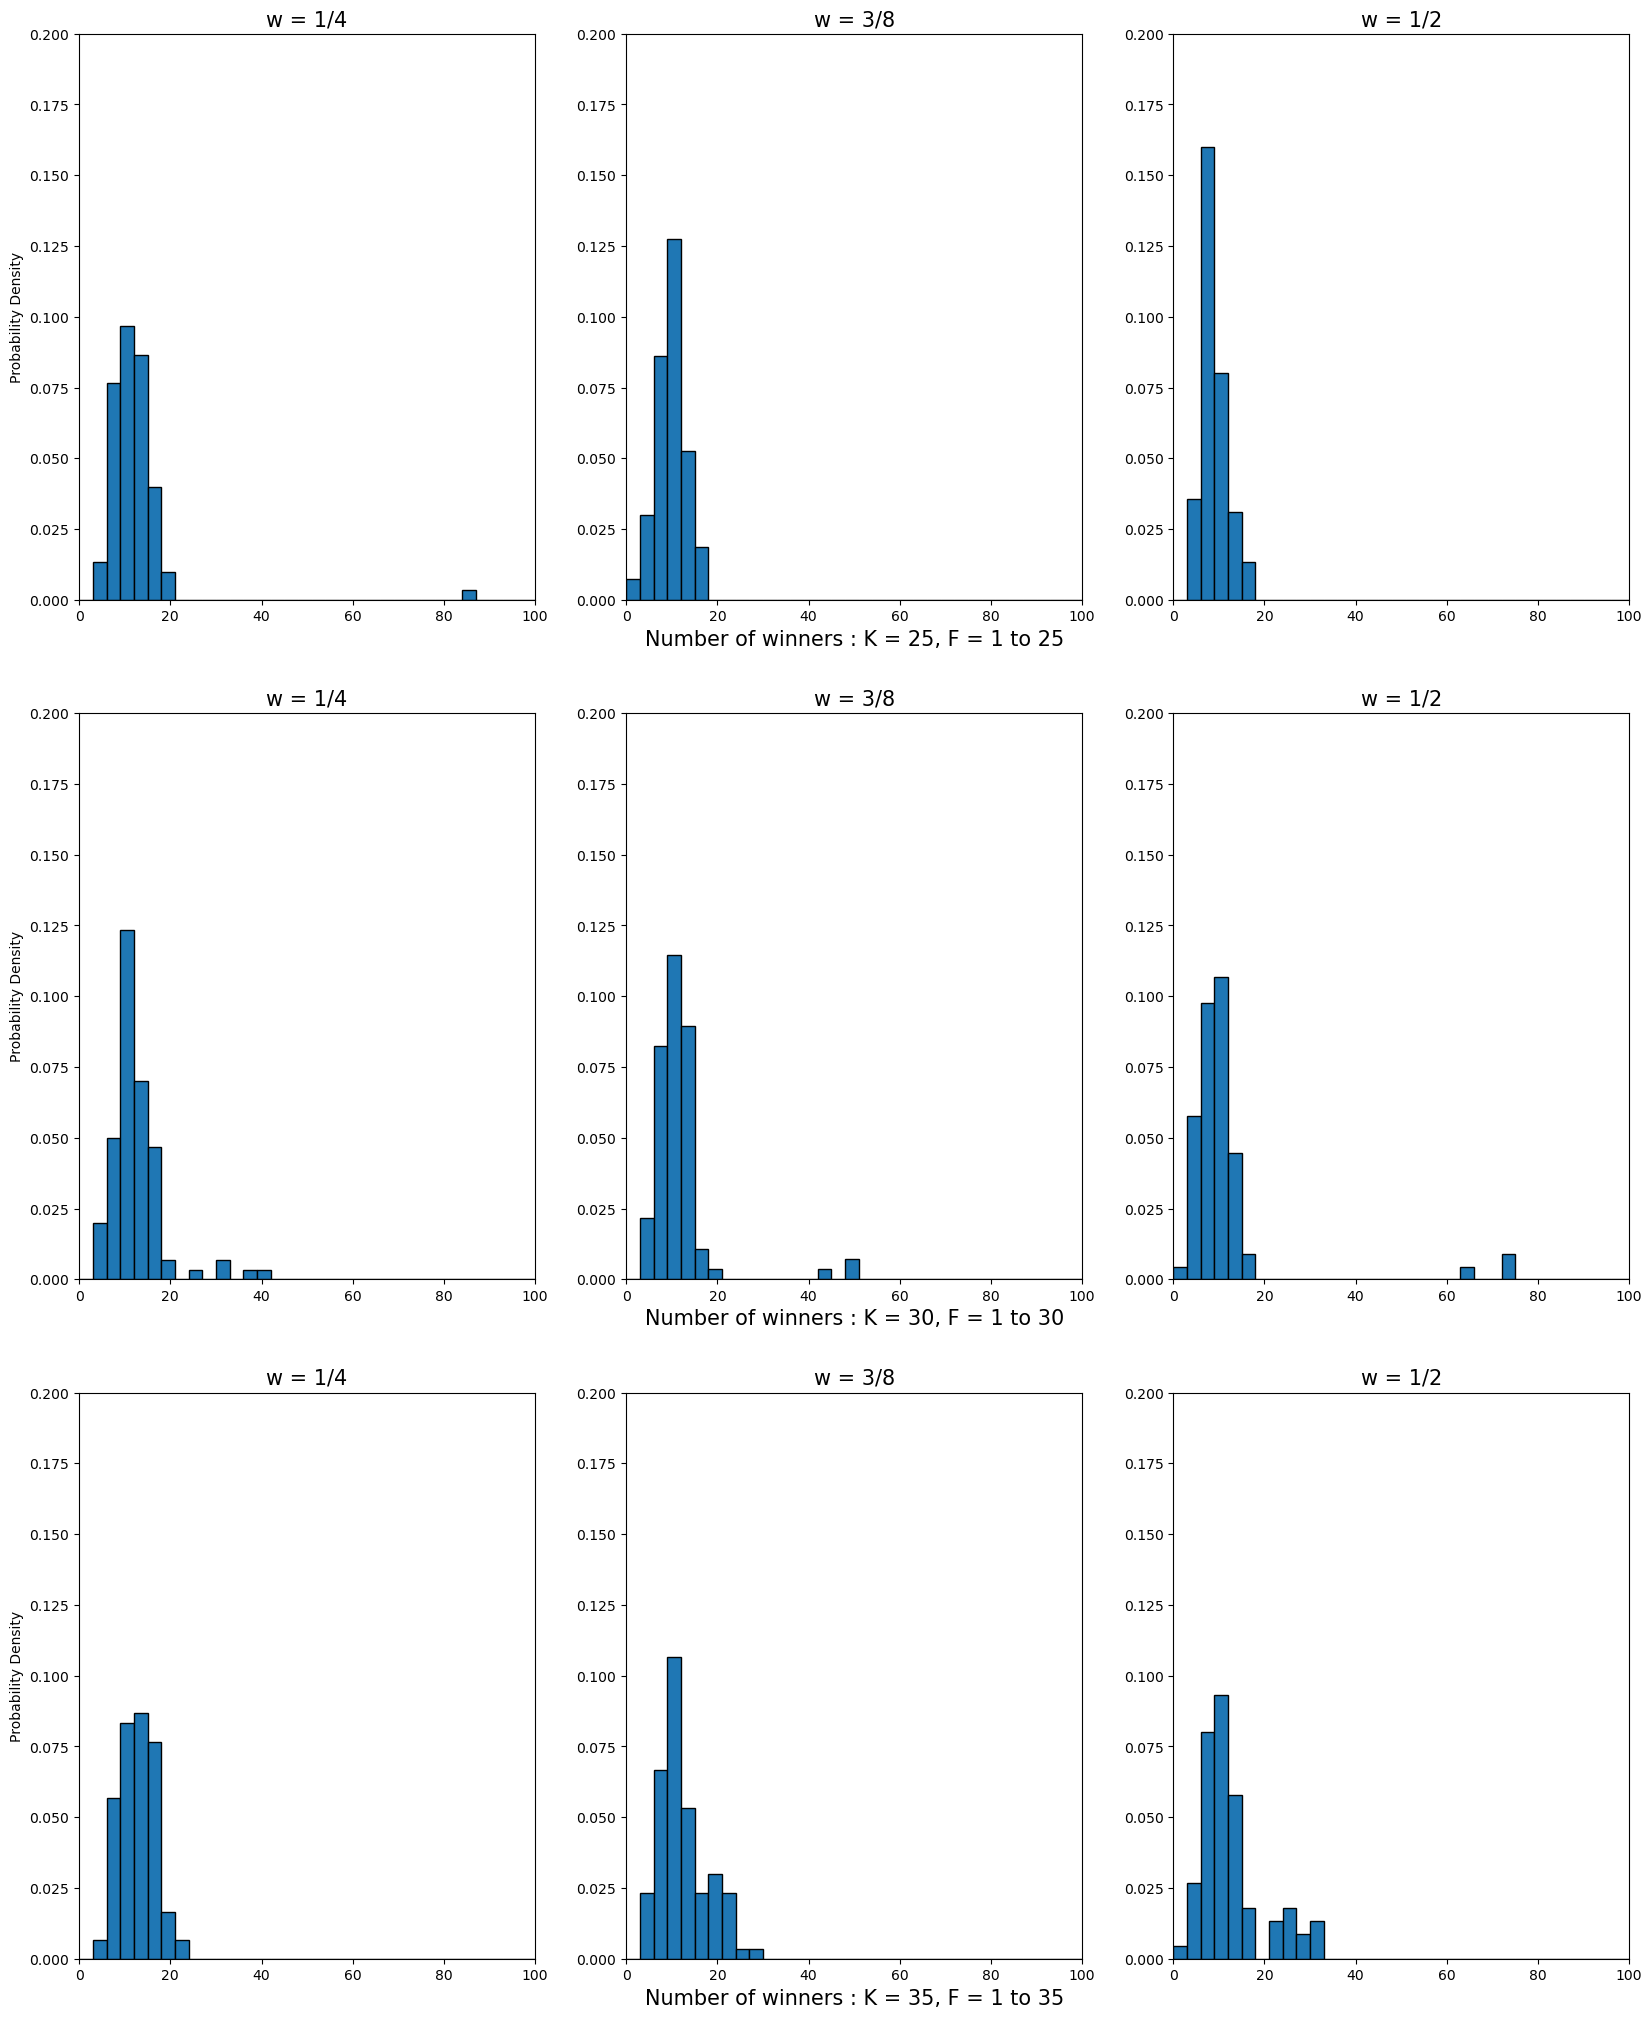

In [26]:
titles = ['1/4', '3/8', '1/2']
datas = [data25_pivoted, data30_pivoted, data35_pivoted]
xlabels = ['K = 25, F = 1 to 25', 'K = 30, F = 1 to 30', 'K = 35, F = 1 to 35']
fig, ax = plt.subplots(3,3, figsize = (20,25))

bins = np.arange(0,200,3)
for k, data in enumerate(datas):
    for i, column in enumerate(data.columns):
        ax[k, i].hist(x = data[column], bins=bins, density = True, edgecolor = 'black')    
        ax[k, i].set_title(f"w = {titles[i]}", fontsize = 15)
        ax[k, 1].set_xlabel(f'Number of winners : {xlabels[k]}', fontsize = 15)
        ax[k, 0].set_ylabel('Probability Density')
        ax[k, i].set_xlim(0,100)
        ax[k, i].set_ylim(0, 0.2)


In [30]:
print((data25_pivoted > 100).sum())
print((data30_pivoted > 100).sum())
print((data35_pivoted > 100).sum())


weight
0.250    2
0.375    3
0.500    3
dtype: int64
weight
0.250    0
0.375    0
0.500    0
dtype: int64
weight
0.250    0
0.375    0
0.500    0
dtype: int64


In [53]:
# Statistics
print(data25_pivoted.mean())
print(data25_pivoted.var())
print(data30_pivoted.mean())
print(data30_pivoted.var())
print(data35_pivoted.mean())
print(data35_pivoted.var())

weight
0.250    13.570000
0.375    13.943820
0.500    15.346667
dtype: float64
weight
0.250     240.974848
0.375     682.894535
0.500    1180.175495
dtype: float64
weight
0.250    12.110000
0.375    11.010753
0.500    10.933333
dtype: float64
weight
0.250     34.725152
0.375     50.054231
0.500    156.684685
dtype: float64
weight
0.250    12.23
0.375    11.75
0.500    12.08
dtype: float64
weight
0.250    14.603131
0.375    26.088384
0.500    50.534054
dtype: float64


In [32]:
raw_data_diffF =extract_data_from_file('result_diffF.txt')

data35_diffF = raw_data_diffF[raw_data_diffF.type == 35]
data30_diffF = raw_data_diffF[raw_data_diffF.type == 30]
data25_diffF = raw_data_diffF[raw_data_diffF.type == 25]

data35_pivoted_diffF = pd.pivot(data = data35_diffF, index = 'd', columns='weight', values = 'result')
data30_pivoted_diffF = pd.pivot(data = data30_diffF, index = 'd', columns='weight', values = 'result')
data25_pivoted_diffF = pd.pivot(data = data25_diffF, index = 'd', columns='weight', values = 'result')

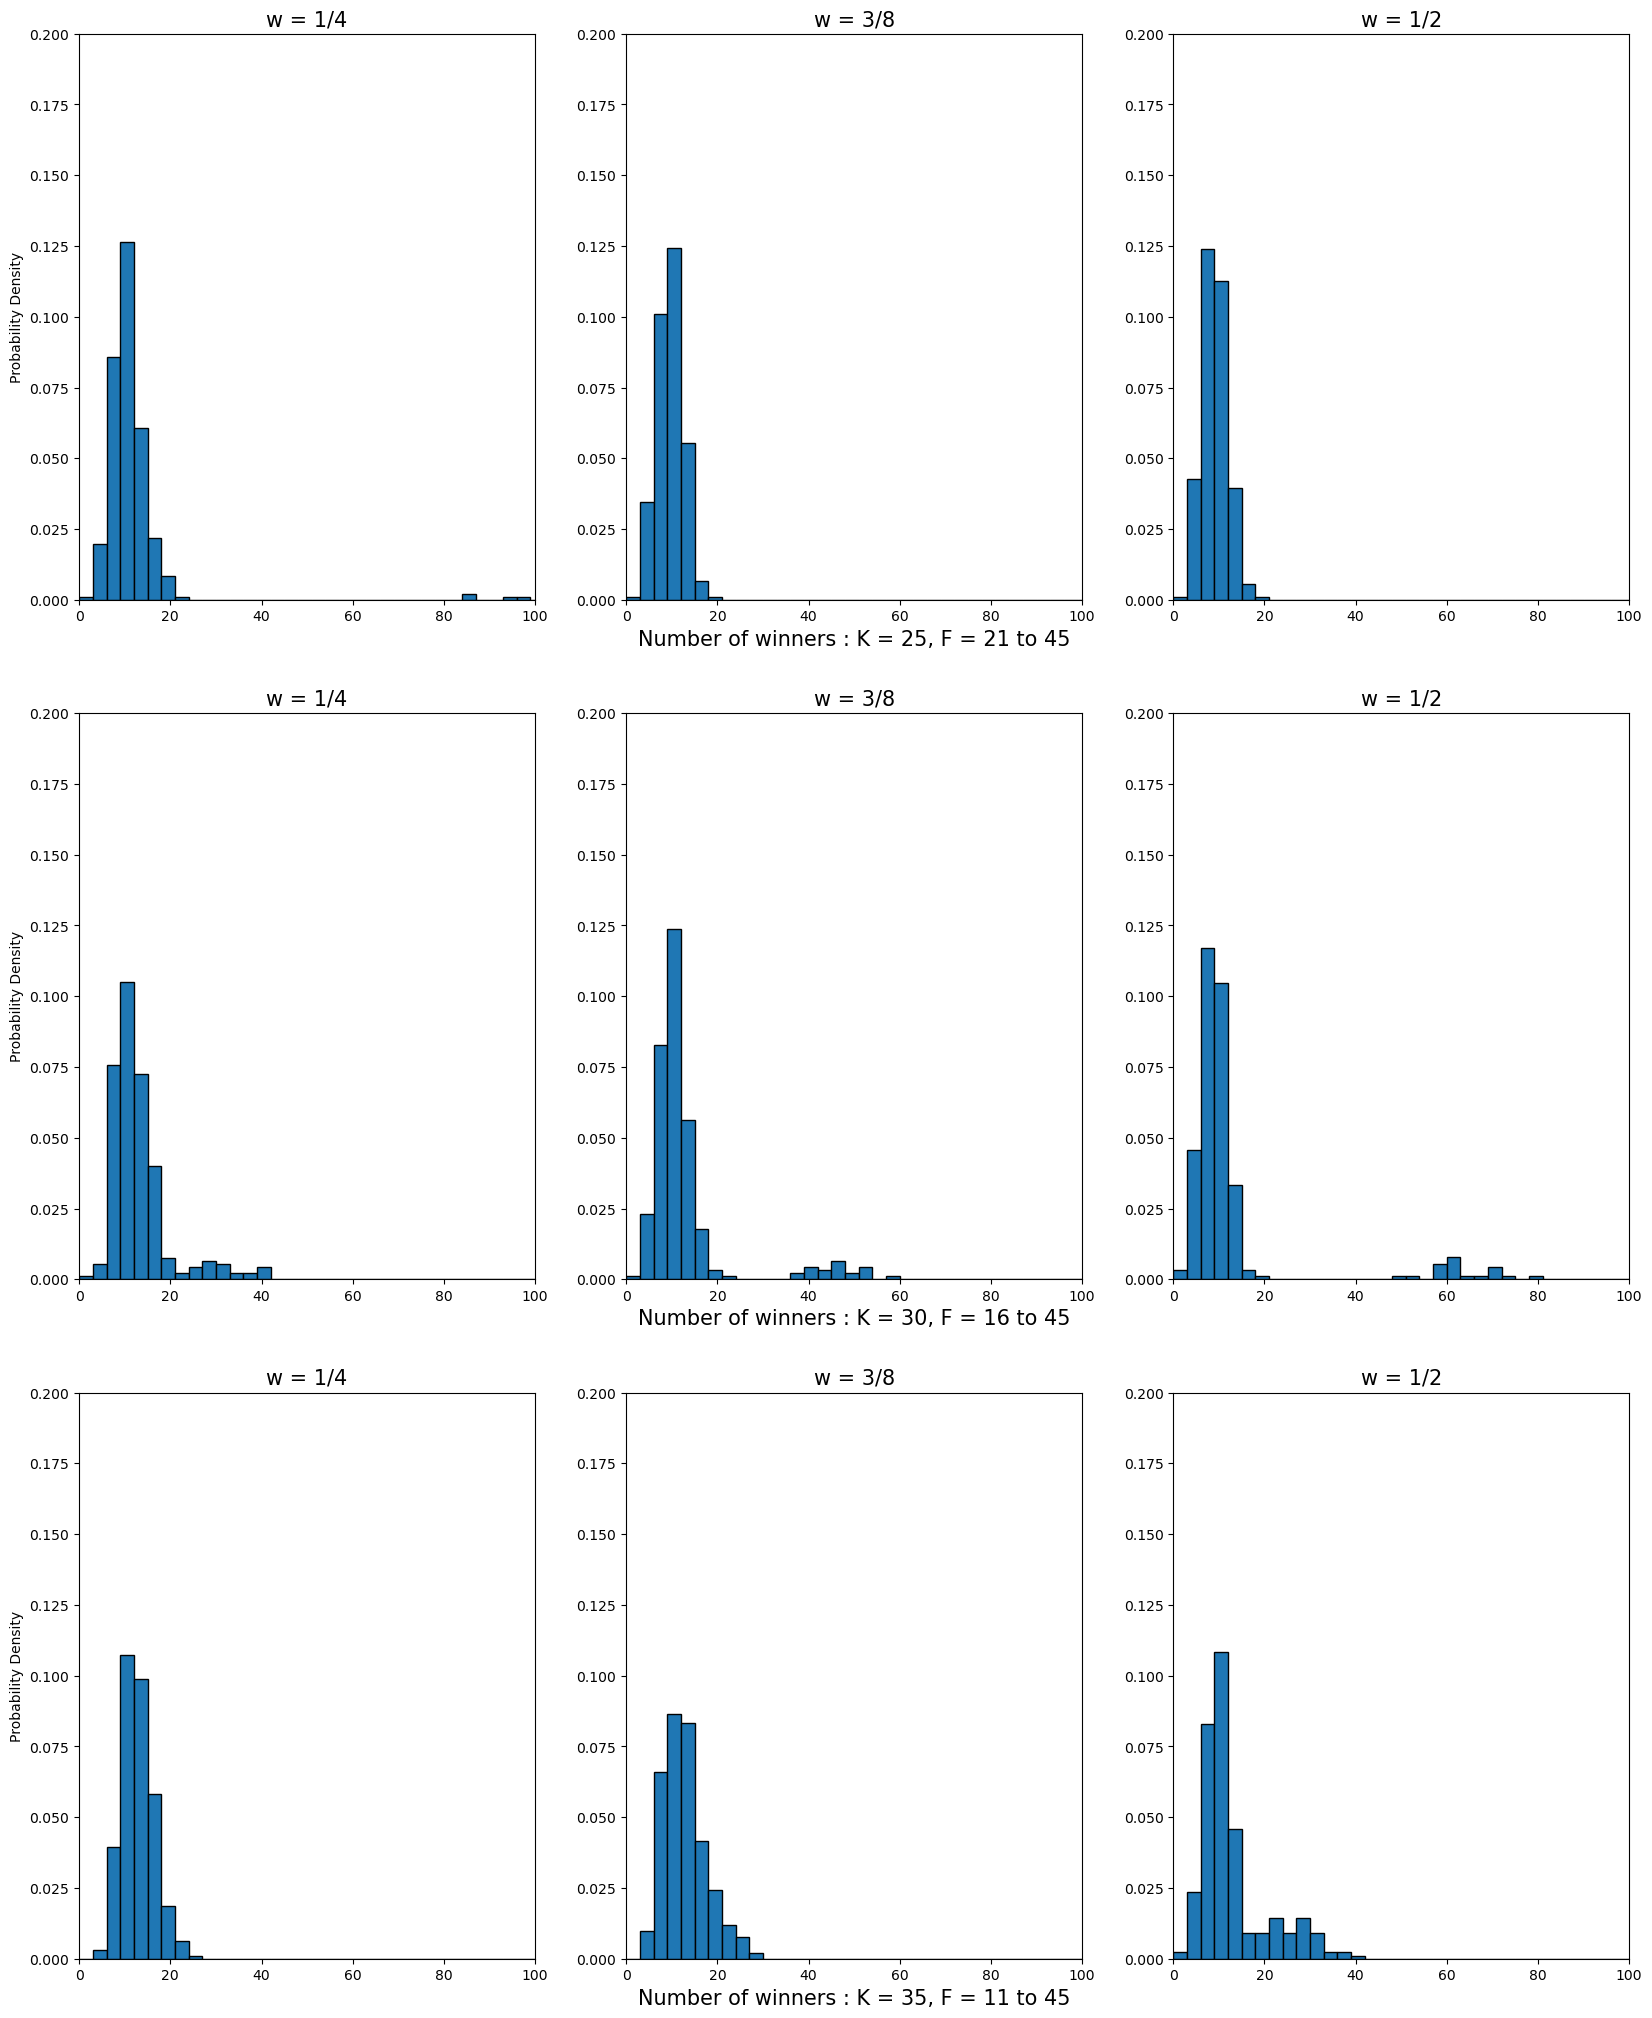

In [33]:
titles = ['1/4', '3/8', '1/2']
datas = [data25_pivoted_diffF, data30_pivoted_diffF, data35_pivoted_diffF]
xlabels = ['K = 25, F = 21 to 45', 'K = 30, F = 16 to 45', 'K = 35, F = 11 to 45']
fig, ax = plt.subplots(3,3, figsize = (20,25))

bins = np.arange(0,200,3)
for k, data in enumerate(datas):
    for i, column in enumerate(data.columns):
        ax[k, i].hist(x = data[column], bins=bins, density = True, edgecolor = 'black')    
        ax[k, i].set_title(f"w = {titles[i]}", fontsize = 15)
        ax[k, 1].set_xlabel(f'Number of winners : {xlabels[k]}', fontsize= 15)
        ax[k, 0].set_ylabel('Probability Density')
        ax[k, i].set_xlim(0,100)
        ax[k, i].set_ylim(0, 0.2)


In [34]:
print((data25_pivoted_diffF > 100).sum())
print((data30_pivoted_diffF > 100).sum())
print((data35_pivoted_diffF > 100).sum())

weight
0.250    4
0.375    8
0.500    8
dtype: int64
weight
0.250    0
0.375    0
0.500    0
dtype: int64
weight
0.250    0
0.375    0
0.500    0
dtype: int64


#### Figure 6? 시뮬레이션


In [ ]:
import pandas as pd
import numpy as np
import random
import itertools
from math import factorial
from functools import lru_cache
from multiprocessing import Process, Queue
from tqdm import tqdm

#Define Classes
numbers = list(range(1,46))
combinations = list(itertools.combinations(numbers, 6))
freqgroup = list(itertools.combinations(list(range(1,31)), 6))
othersgroup = list(set(combinations) - set(freqgroup))
group = [freqgroup, othersgroup]


#define sampling functions
def rticket(batch_size):
    tickets = np.empty((batch_size, 6), dtype=np.int32)
    for i in range(batch_size):
        ticket = np.random.choice(np.arange(1, 46), 6, replace=False)
        tickets[i] = np.sort(ticket)
    return tickets


def nrticket1(c, w, size): 
  class_prob = [w, 1-w]
  tickets = []
  for _ in range(size):
    group = int(np.random.choice(list(range(2)), size=1, p=class_prob))
    ticket = sorted(random.sample(c[group], 1))
    tickets.append(ticket)
  return np.array(tickets)

# work
B = 100000000
batch_size = 1000000
R = batch_size // 3
NR = batch_size - R
iter = B//batch_size

w_grid_30 = [0.1, 0.2, 0.5]

def work30(start, end):
  for d in range(start, end):
    draw =  nrticket1(c = group, w = 0.3, size = 1).ravel()
    for weight in w_grid_30:
        results = []
        for _ in tqdm(range(iter)): #배치 반복 횟수.
            auto = rticket(R)
            manual = nrticket1(group, w = weight, size=NR).ravel().reshape(NR, -1)
            result = np.sum(np.all(draw == auto, axis=1)) + np.sum(np.all(draw == manual, axis=1))
            results.append(result)
        print("d : %d, weight = %f, result = %d"%(d, weight, sum(results)))
  return


if __name__ == '__main__':
  result = Queue()
  processes = []
  for i in range(75):
    p = Process(target=work30, args=(10*i, 10*(i+1)))
    processes.append(p)

  # 모든 프로세스를 시작합니다.
  for p in processes:
      p.start()

  # 모든 프로세스가 종료될 때까지 기다립니다.
  for p in processes:
      p.join()

  result.put('STOP')
  total = 0


  while True:
      tmp = result.get()
      
      
      if tmp == 'STOP':
          break
      else:
          total += tmp

In [14]:
# 시뮬레이션 시각화

# 시뮬레이션 시각화
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

# Regular expression to capture the data
pattern = re.compile(r"group(\d+),\s*d\s*:\s*(\d+),\s*weight\s*=\s*([\d.]+),\s*result\s*=\s*(\d+)")

# Function to read a file and extract data using the regex
def extract_data_from_file(file_path):
    extracted_data = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                group_val = int(match.group(1))
                d_val = int(match.group(2))
                weight_val = float(match.group(3))
                result_val = int(match.group(4))
                
                extracted_data.append({
                    'group' : group_val,
                    'd': d_val,
                    'weight': weight_val,
                    'result': result_val
                })
    
    return pd.DataFrame(extracted_data)


In [15]:
temp =extract_data_from_file('result_nonrandom_draw.txt')

In [27]:
temp_25 = temp[temp.group == 25]
temp_30 = temp[temp.group == 30]
temp_35 = temp[temp.group == 35]

temp_25_pivoted = pd.pivot(temp_25, index = 'd', columns = 'weight', values = 'result')
temp_30_pivoted = pd.pivot(temp_30, index = 'd', columns = 'weight', values = 'result')
temp_35_pivoted = pd.pivot(temp_35, index = 'd', columns = 'weight', values = 'result')


In [37]:
temp_25_pivoted

weight,0.250,0.375,0.500
d,,,
0,12,10,5
1,96,156,181
2,8,11,4
3,12,8,4
4,5,8,5
...,...,...,...
495,108,133,198
496,12,9,11
497,22,7,8


In [42]:
datas = [temp_25_pivoted, temp_30_pivoted, temp_35_pivoted]
group = ['25','30','35']
for i, data in enumerate(datas):
    print('group:',group[i])
    print(data.mean())
    print(data.var())

group: 25
weight
0.250    27.890
0.375    36.708
0.500    45.070
dtype: float64
weight
0.250    1244.851603
0.375    3032.066870
0.500    5450.437976
dtype: float64
group: 30
weight
0.250    15.242
0.375    16.892
0.500    18.804
dtype: float64
weight
0.250     93.346128
0.375    242.914164
0.500    438.105796
dtype: float64
group: 35
weight
0.250    12.384
0.375    14.060
0.500    15.374
dtype: float64
weight
0.250    13.848240
0.375    37.122645
0.500    76.194513
dtype: float64


In [44]:
temp_35_pivoted.var()

weight
0.250    13.848240
0.375    37.122645
0.500    76.194513
dtype: float64

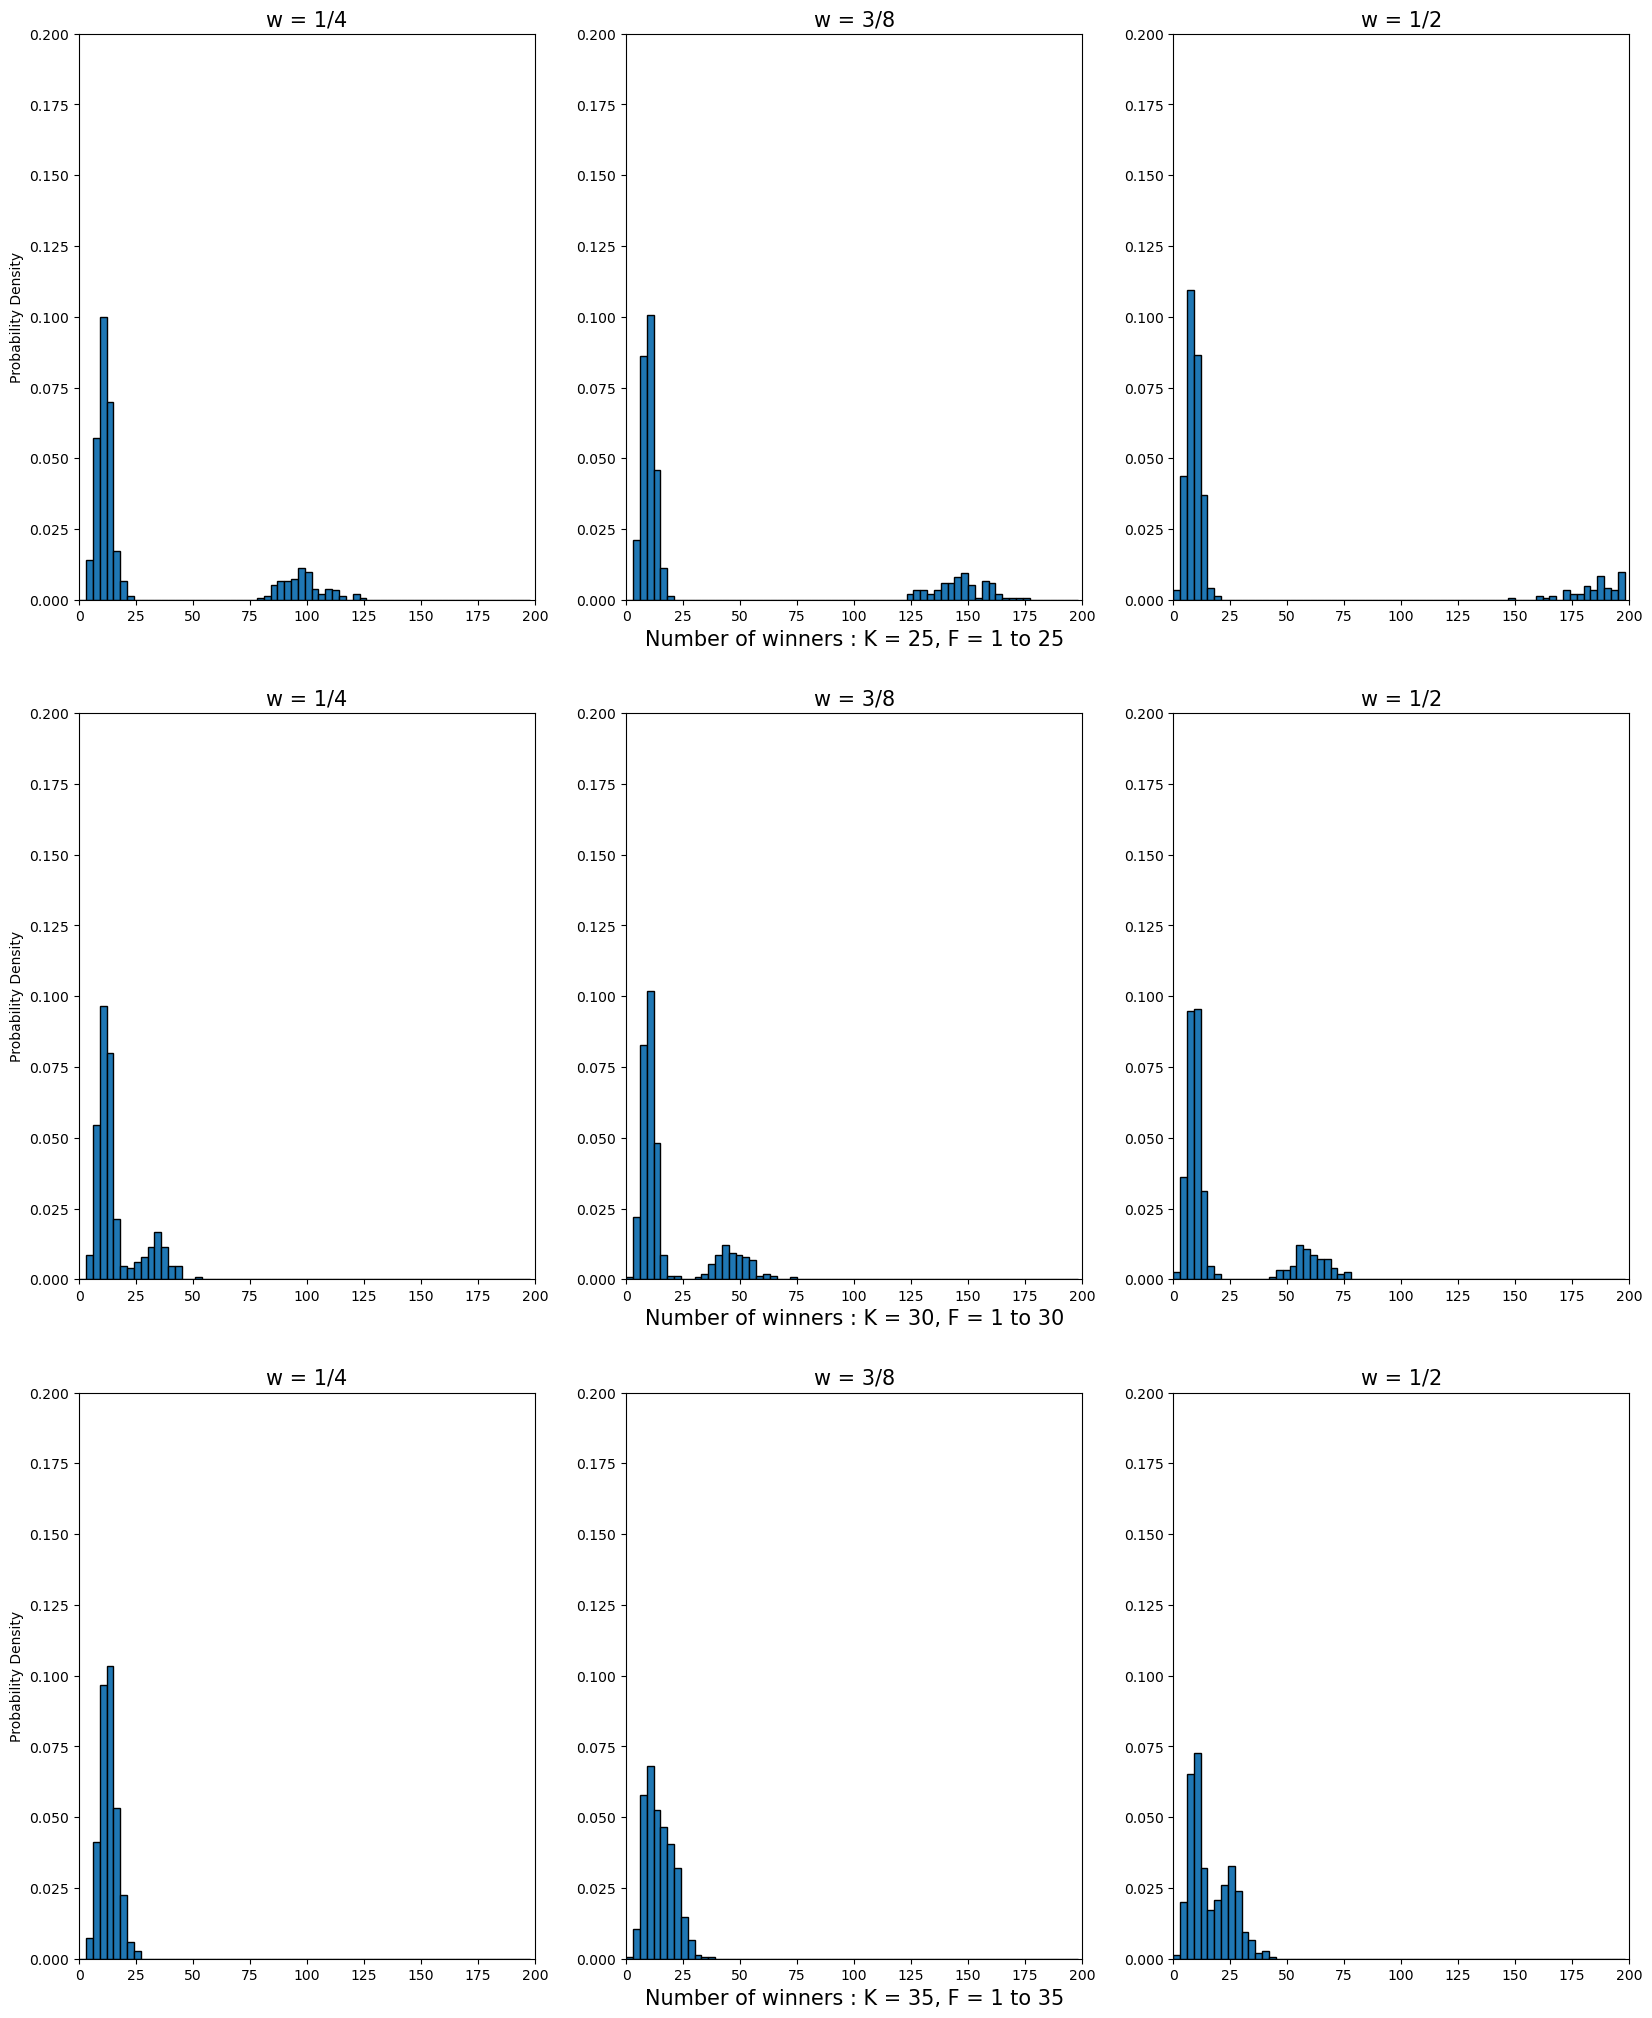

In [35]:
titles = ['w = 1/4', 'w = 3/8', 'w = 1/2']
datas = [temp_25_pivoted, temp_30_pivoted, temp_35_pivoted]
xlabels = ['K = 25, F = 1 to 25', 'K = 30, F = 1 to 30', 'K = 35, F = 1 to 35']

fig, ax = plt.subplots(3,3, figsize = (20,25))
bins = np.arange(0,200,3)
for k, data in enumerate(datas):
    for i, column in enumerate(data.columns):
        ax[k, i].hist(x = data[column], bins=bins, density = True, edgecolor = 'black')    
        ax[k, i].set_title(f"{titles[i]}", fontsize = 15)
        ax[k, 1].set_xlabel(f'Number of winners : {xlabels[k]}', fontsize= 15)
        ax[k, 0].set_ylabel('Probability Density')
        ax[k, i].set_xlim(0,200)
        ax[k, i].set_ylim(0, 0.2)